In [1]:
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as au
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import xarray as xr
import pandas as pd

## The files used in this notebook and full data can be downloaded from using Globus

* See athena-tigress website: https://princetonuniversity.github.io/astro-tigress/intro.html

In [2]:
from read_vtk import read_vtk
from read_hst import read_hst

fname_vtk = '../R8_4pc.0300.vtk'
fname_hst = '../R8_4pc.hst'
ds = read_vtk(fname_vtk)
h = read_hst(fname_hst)

In [3]:
# List of available 3d data cube. We will need density, velocity, and pressure.
ds.field_list

['density',
 'velocity',
 'pressure',
 'cell_centered_B',
 'gravitational_potential',
 'specific_scalar[0]',
 'specific_scalar[1]',
 'specific_scalar[2]']

# Simulation domain and unit information

* The code unit for length is parsec.
* The code unit for velocity is km/s.
* The code unit  for density is set such that rho_code=1 corresponds to nH=1/cm^3.
* Left/right edge
* Lx: domain size
* dx[0] : dx
* dx[1] : dy
* dx[2] : dz

In [4]:
ds.domain

{'all_grid_equal': True,
 'ngrid': 1,
 'le': array([-512., -512., -512.], dtype=float32),
 're': array([512., 512., 512.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 1024.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([256, 256, 256]),
 'ndim': 3,
 'time': 300.0002}

In [5]:
# code unit are stored as astropy.units objects
ds.u.length, ds.u.mass, ds.u.time, ds.u.velocity 

(<Quantity 1. pc>,
 <Quantity 0.03529472 solMass>,
 <Quantity 3.08567758e+13 s>,
 <Quantity 1. km / s>)

In [6]:
# To convert code time to Myr, we can multiply code_time by u.Myr
# That is, u.Myr = code.time.to('Myr').value
ds.u.Myr, ds.u.kms, ds.u.Msun, ds.u.pc, ds.u.pc

(0.9777922216807893, 1.0, 0.035294721634998916, 1.0, 1.0)

In [7]:
# History output
h.columns

Index(['time', 'dt', 'mass', 'totalE', 'x1Mom', 'x2Mom', 'x3Mom', 'x1KE',
       'x2KE', 'x3KE', 'x1ME', 'x2ME', 'x3ME', 'gravPE', 'scalar0', 'scalar1',
       'scalar2', 'heat_ratio', 'ftau', 'x2dke', 'x1KE_2p', 'x2KE_2p',
       'x3KE_2p', 'F3h2', 'F3h1', 'F3w', 'F3u', 'F3c', 'F3_upper', 'F3_lower',
       'F3_metal_upper', 'F3_metal_lower', 'H2', 'H2h2', 'H2h1', 'H2w', 'H2u',
       'H2c', 'P', 'P_2p', 'Pth', 'Pth_2p', 'Pturb', 'Pturb_2p', 'nmid',
       'nmid_2p', 'Vmid_2p', 'Vh2', 'Vh1', 'Vw', 'Vu', 'Vc', 'Mh2', 'Mh1',
       'Mw', 'Mu', 'Mc', 'B1', 'B2', 'B3', 'sfr10', 'sfr40', 'sfr100', 'msp',
       'mtotal', 'metal_sp'],
      dtype='object')

Text(0, 0.5, '$\\Sigma_{\\rm SFR}\\;[M_{\\odot}\\,{\\rm kpc}^{-2}\\,{\\rm yr}^{-1}]$')

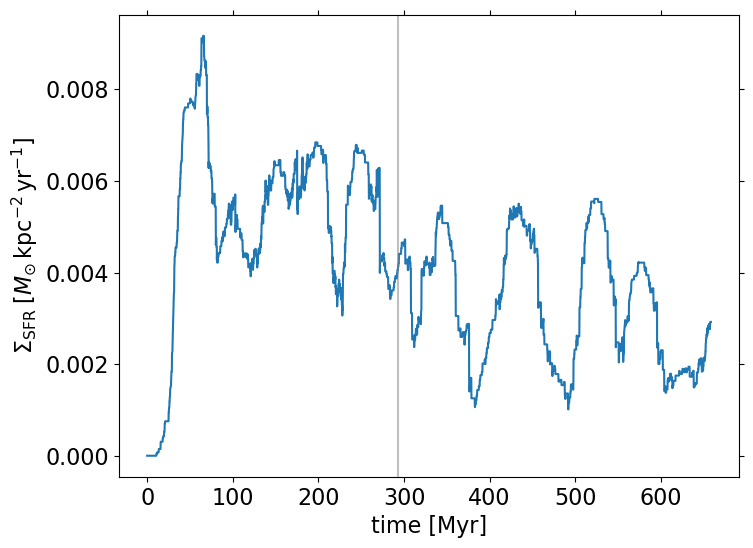

In [8]:
## Star formation rate surface density as a function of time
h['time_Myr'] = h['time']*ds.u.Myr
plt.plot(h['time_Myr'],h['sfr40'])
plt.axvline(ds.domain['time']*ds.u.Myr, color='grey', alpha=0.5)
plt.xlabel('time [Myr]')
plt.ylabel(r'$\Sigma_{\rm SFR}\;[M_{\odot}\,{\rm kpc}^{-2}\,{\rm yr}^{-1}]$')

In [9]:
def get_temp(ds):
    # Calculate temperature from T1 = P/(nH*kB) and mean molecular weight mu(T1)
    # Fig 1 in Kim & Ostriker (2017) shows mu(T)
    from coolftn_tigress_classic import coolftn
    cf = coolftn()
    dd = ds.get_field(['density','pressure'])
    return xr.DataArray(cf.get_temp((dd['pressure']*ds.u.pressure/dd['density']/\
                                        ds.u.muH/ac.k_B.cgs.value).data),
                                     coords={'z': dd['z'].values,
                                             'y': dd['y'].values,
                                             'x': dd['x'].values},
                                              dims=['z', 'y', 'x'])

dd = ds.get_field(['density', 'pressure', 'velocity'])
dd['T'] = get_temp(ds)

# Rename field names
dd = dd.rename({'density':'nH', 'pressure':'P',
                'velocity1':'vx','velocity2':'vy','velocity3':'vz'})
dd

<xarray.Dataset>
Dimensions:  (z: 256, y: 256, x: 256)
Coordinates:
  * x        (x) float64 -510.0 -506.0 -502.0 -498.0 ... 498.0 502.0 506.0 510.0
  * y        (y) float64 -510.0 -506.0 -502.0 -498.0 ... 498.0 502.0 506.0 510.0
  * z        (z) float64 -510.0 -506.0 -502.0 -498.0 ... 498.0 502.0 506.0 510.0
Data variables:
    nH       (z, y, x) float32 0.006938 0.004033 0.001905 ... 0.03407 0.02854
    P        (z, y, x) float32 1.475 2.831 4.175 4.734 ... 2.236 3.007 8.573
    vx       (z, y, x) float32 40.71 39.92 37.81 35.05 ... 56.62 51.2 39.16
    vy       (z, y, x) float32 7.212 10.57 14.13 15.9 ... -14.72 -16.87 -21.0
    vz       (z, y, x) float32 -33.13 -35.47 -36.35 -35.38 ... 14.68 17.92 24.49
    T        (z, y, x) float32 1.871e+04 5.516e+04 ... 1.28e+04 2.475e+04
Attributes:
    all_grid_equal:  True
    ngrid:           1
    le:              [-512. -512. -512.]
    re:              [512. 512. 512.]
    dx:              [4. 4. 4.]
    Lx:              [1024. 1024. 1024.]
    center:          [0. 0. 0.]
    Nx:              [256 256 256]
    ndim:            3
    time:            300.0002

In [10]:
# Integration along the z-axis (face on view)
dz = ds.domain['dx'][2]*ac.pc.cgs # Delta z in cm
NH = dd['nH'].sum(dim='z')*dz.cgs.value
dz.to('pc')

<Quantity 4. pc>

## Plot density projection NH

<xarray.DataArray 'nH' (y: 1, x: 1)>
array([[2.329877e+22]], dtype=float32)
Coordinates:
  * x        (x) float64 -182.0
  * y        (y) float64 414.0

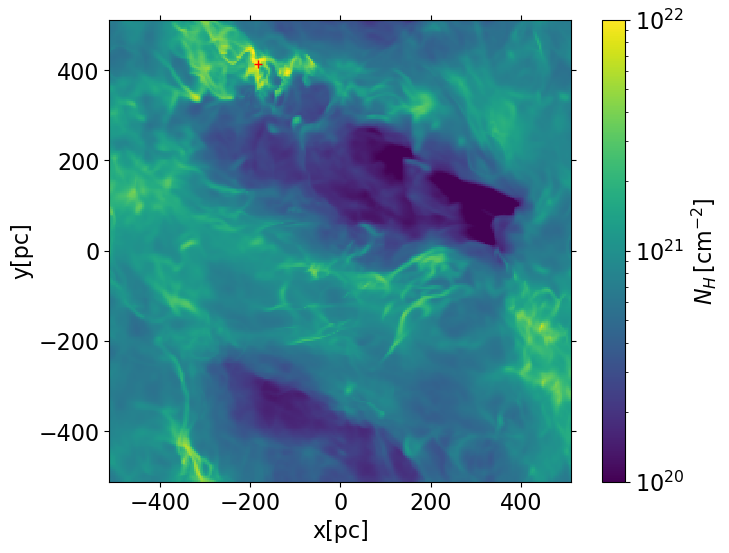

In [11]:
plt.pcolormesh(dd['x'],dd['y'],NH,norm=LogNorm(1e20,1e22),shading='nearest')
#plt.pcolormesh(dd['x'],dd['y'],NH,norm=Normalize(0, 1e22),shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('y[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

# Mark the position where NH is maximum
NHmax = NH.where(NH == NH.max(), drop=True)
plt.plot(NHmax.x,NHmax.y,'r+')
NHmax

## Profile along a single line of sight

In [12]:
# los = dd[['nH','T','vz']].sel(x=200.0,y=200.0, method='nearest').squeeze()
los = dd[['nH','T','vz']].sel(x=NHmax.x, y=NHmax.y, method='nearest').squeeze()
# los.to_array().plot(hue='variable',yscale='log')

(-30.0, 30.0)

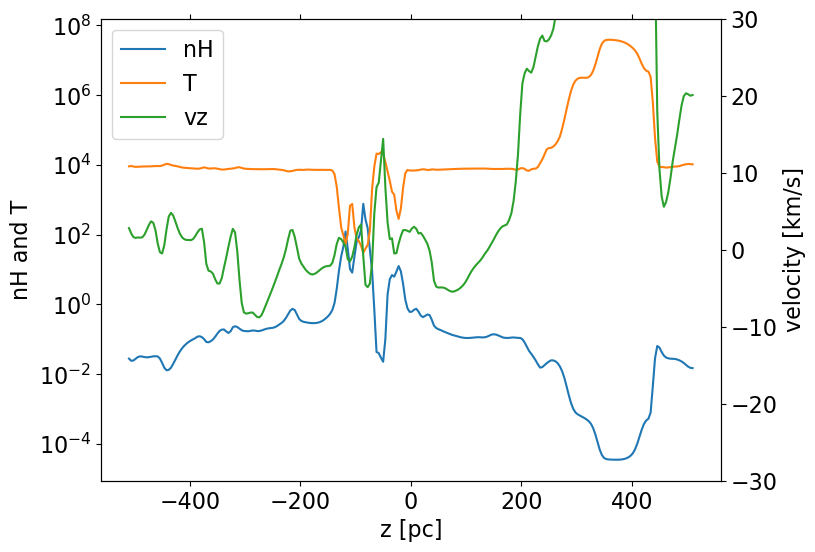

In [13]:
plt.semilogy(los['z'],los['nH'], label='nH')
plt.semilogy(los['z'],los['T'], label='T')
plt.xlabel('z [pc]')
plt.ylabel('nH and T')
plt.plot([],[],c='C2',label='vz') # Don't do this in anywhere remotely close to any production code
plt.legend()

axt = plt.gca().twinx()
axt.plot(los['z'],los['vz'], c='C2', label='vz')
axt.set_ylabel('velocity [km/s]')
axt.set_ylim(-30,30)

## Histogram of gas temperature

Text(0, 0.5, '# of cells')

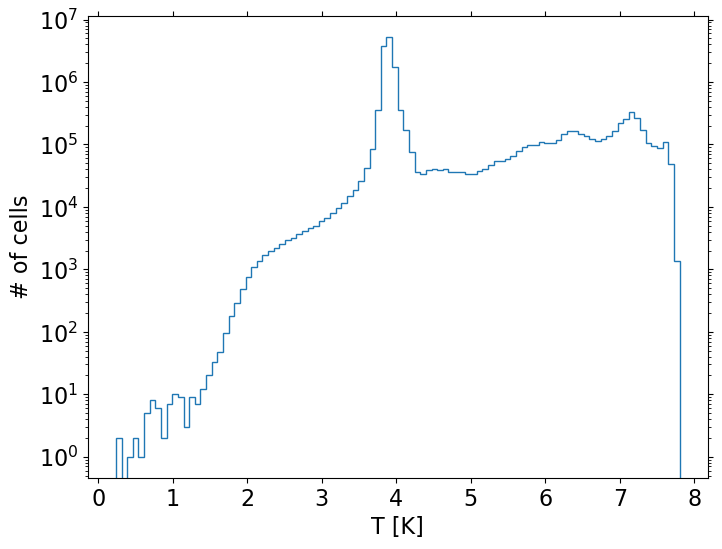

In [14]:
plt.hist(np.log10(dd['T'].data.flatten()),bins=100,histtype='step');
plt.yscale('log')
plt.xlabel('T [K]')
plt.ylabel('# of cells')

## density weighted average temperature along z (excluding hot gas with T > 1.5e4 K)

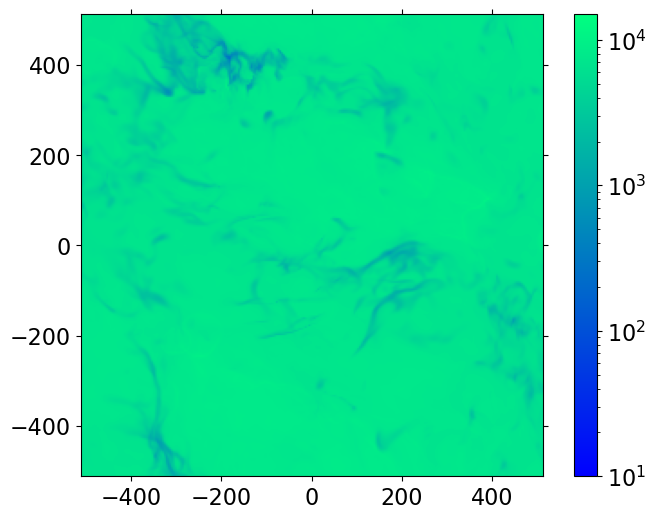

In [15]:
T_thres = 1.5e4 # threshold temperature below which gas is considered as HI
extent = (ds.domain['le'][0], ds.domain['re'][0],
          ds.domain['le'][1], ds.domain['re'][1])
dd_ = dd.where(dd['T'] < T_thres)
im = plt.imshow((dd_['T']*dd_['nH']).sum(dim='z')/(dd_['nH']).sum(dim='z'),
                norm=LogNorm(1e1,T_thres), cmap=plt.cm.winter, origin='lower', extent=extent)
plt.colorbar(im)

## Slice of temperature

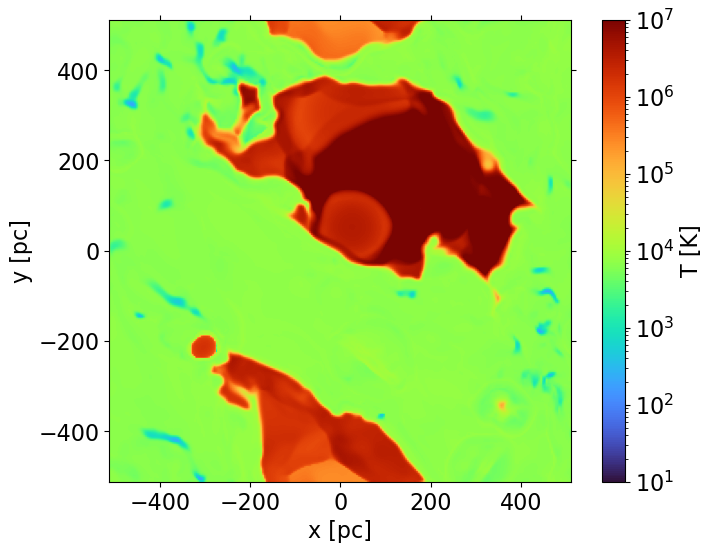

In [16]:
im = plt.imshow(dd['T'].sel(z=0, method='nearest'), norm=LogNorm(1e1,1e7),
                cmap=plt.cm.turbo, origin='lower', extent=extent)
plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.colorbar(im, label='T [K]')


# Plot a subregion of interest

* Set threshold density to exclude (assuming that they are molecular)

(300.0, 500.0)

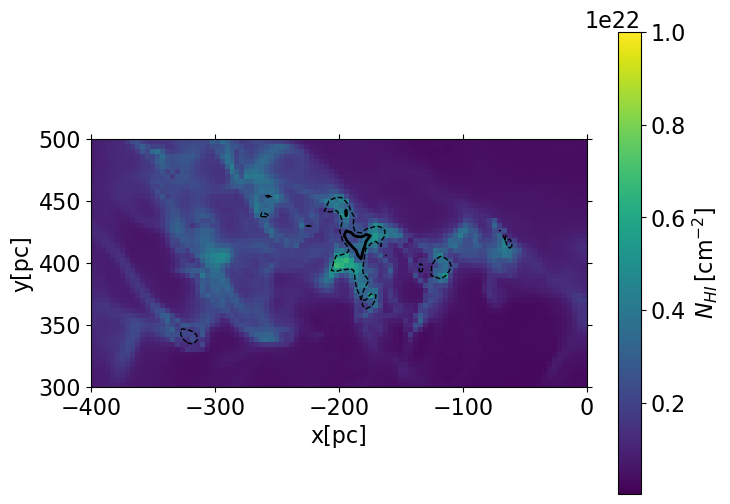

In [17]:
nH_thres_mol = 50

# Integration along the z-axis (face on view)
dz = ds.domain['dx'][2]*ac.pc
NH = dd['nH'].sum(dim='z')*dz.cgs.value

# Integration along the y-axis excluding molecular gas
NHI = dd['nH'].where(dd['nH'] < nH_thres_mol).sum(dim='z')*dz.cgs.value

NHI.plot(vmax=1e22, cbar_kwargs=dict(label=r'$N_{HI}\,[{\rm cm}^{-2}]$'))
NH.plot.contour(levels=[5e21,1e22],colors=['k','k'], linestyles=['--','-'],
                linewidths=[1,2])

plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('y[pc]')
plt.xlim(-400,0)
plt.ylim(300,500)

### Select LOSs

In [18]:
# Set thershold HI column density
NHI_thres = 5e21

# Define a region of interest
xmin,xmax = (-400,0)
ymin,ymax = (300,500)
# find x,y pairs that satisfy the threshold condition within the regions of interest
xypair = NHI.sel(x=slice(xmin,xmax), y=slice(ymin,ymax))

# Select high-column LOSs
# xypair = xypair.where(np.logical_and(NHI < NHI_thres, NHI > 1e21),
#                       drop=True).stack(xy=['x','y']).dropna(dim='xy').xy

# Select LOSs with somewhat lower column
xypair = xypair.where(np.logical_and(NHI < 1e21, NHI > 1e20),
                      drop=True).stack(xy=['x','y']).dropna(dim='xy').xy
print("There are a total of {} LOSs satisfying our criteria".format(len(xypair)))
xypair

There are a total of 2590 LOSs satisfying our criteria


<xarray.DataArray 'xy' (xy: 2590)>
array([(-398.0, 302.0), (-398.0, 306.0), (-398.0, 310.0), ..., (-2.0, 490.0),
       (-2.0, 494.0), (-2.0, 498.0)], dtype=object)
Coordinates:
  * xy       (xy) object MultiIndex
  * x        (xy) float64 -398.0 -398.0 -398.0 -398.0 ... -2.0 -2.0 -2.0 -2.0
  * y        (xy) float64 302.0 306.0 310.0 314.0 ... 486.0 490.0 494.0 498.0

In [19]:
# set number of los to choose (randomly selected within LOSs satisfying the threshold condition)
Nlos = 20
idx = (np.random.rand(Nlos)*len(xypair)).astype('int')
idx.sort()
xypair_sel = xypair.sortby('y').data[idx]
xypair_sel

array([(-334.0, 302.0), (-146.0, 302.0), (-250.0, 310.0), (-210.0, 314.0),
       (-230.0, 318.0), (-134.0, 326.0), (-226.0, 362.0), (-334.0, 366.0),
       (-98.0, 370.0), (-94.0, 382.0), (-134.0, 446.0), (-150.0, 466.0),
       (-114.0, 474.0), (-54.0, 478.0), (-398.0, 482.0), (-390.0, 490.0),
       (-162.0, 490.0), (-122.0, 490.0), (-110.0, 494.0), (-34.0, 494.0)],
      dtype=object)

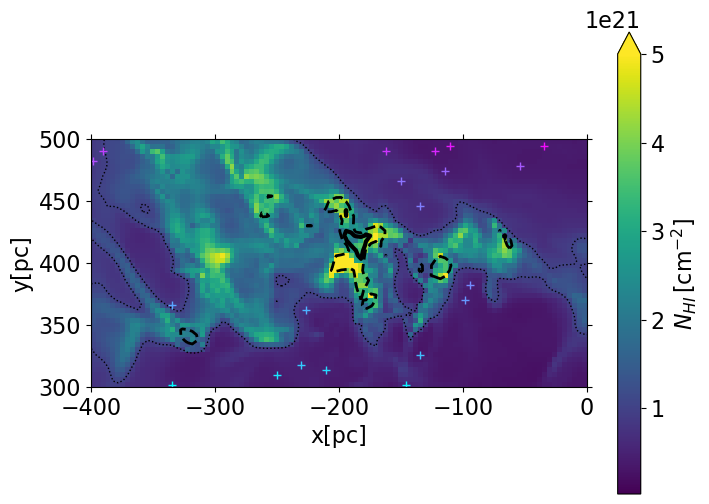

In [20]:
NHI.plot(vmax=5e21, cbar_kwargs=dict(label=r'$N_{HI}\,[{\rm cm}^{-2}]$'))
NH.plot.contour(levels=[1e21, 5e21, 1e22],colors=['k','k'], linestyles=[':','--','-'],
                linewidths=[1,2,3])

plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('y[pc]')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

# now add LOSs
for i,(x,y) in enumerate(xypair_sel):
    plt.plot(x,y,'+',color=plt.cm.cool(i/Nlos))

(-20.0, 20.0)

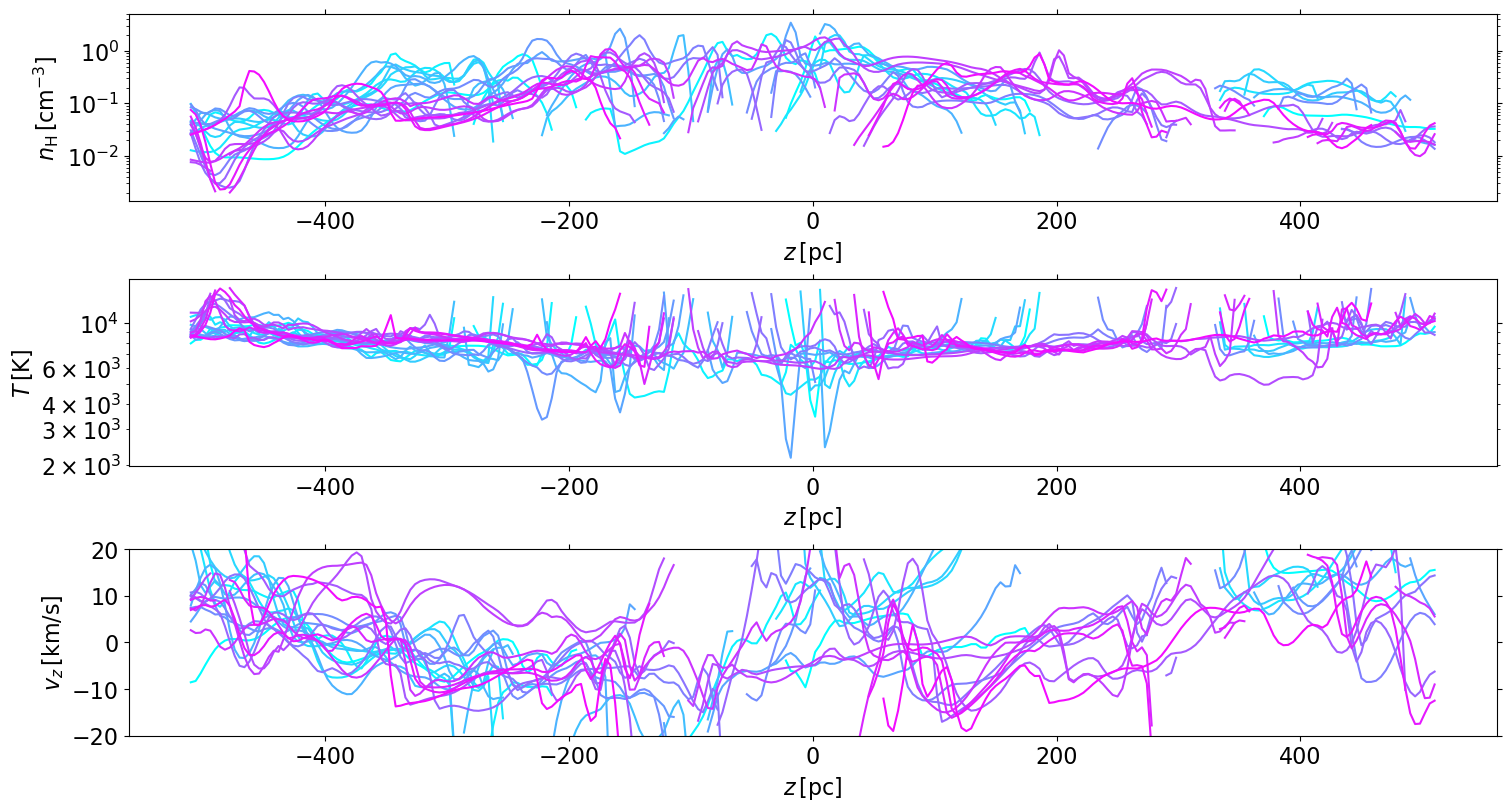

In [21]:
fig,axes = plt.subplots(3,1,figsize=(15,8),constrained_layout=True)
logs = dict(nH=True, T=True, vz=False)
labels = dict(nH=r'$n_{\rm H}\,[{\rm cm}^{-3}]$',
              T=r'$T\,[{\rm K}]$',
              vz=r'$v_z\,[{\rm km/s}]$')

for i,(x,y) in enumerate(xypair_sel):
    los = dd[['nH','T','vz']].sel(x=x, y=y).squeeze()
    for f, ax in zip(list(los.variables),axes):
        plt.sca(ax)
        plt.plot(los.z, los[f].where(los['T'] < T_thres), color=plt.cm.cool(i/Nlos))
        if logs[f]:
            plt.yscale('log')

        plt.ylabel(labels[f])
        plt.xlabel(r'$z\,[{\rm pc}]$')
        
axes[2].set_ylim(-20,20)

## Synthetic HI
* Following the method presented in https://ui.adsabs.harvard.edu/abs/2014ApJ...786...64K/abstract

* Assuming that the WF effect is efficient enough to make T_spin = T_k based on Ly alpha radiation transfer study https://ui.adsabs.harvard.edu/abs/2020ApJS..250....9S/abstract

\begin{equation}
N_{\rm H} = 1.813\times 10^{18}\,{\rm cm}^{-2}\int T_{\rm B} \frac{\tau}{1 - e^{-\tau}} d(v/({\rm km}\,{\rm s}^{-1}))$
\end{equation}

In [22]:
from synthetic_HI import los_to_HI_axis_proj
help(los_to_HI_axis_proj)

Help on function los_to_HI_axis_proj in module synthetic_HI:

los_to_HI_axis_proj(dens, temp, vel, vchannel, deltas=1.0, los_axis=1, verbose=False)
    inputs:
        dens: number density of hydrogen in units of 1/cm^3
        temp: temperature in units of K
        vel: line-of-sight velocity in units of km/s
        vchannel: velocity channel in km/s
    parameters:
        deltas: length of line segments in units of pc
        memlim: memory limit in GB
        los_axis: 0 -- z, 1 -- y, 2 -- x
    outputs: a dictionary
        TB: the brightness temperature
        tau: optical depth



Text(0, 0.5, '$\\exp (-\\tau)$')

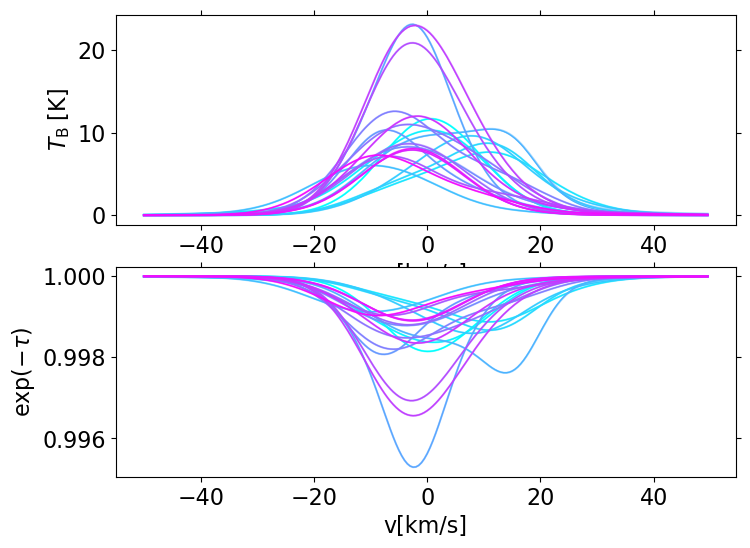

In [23]:
delta_s = ds.domain['dx'][2]
fig,axes = plt.subplots(2,1)
for i,(x,y) in enumerate(xypair_sel):
    los = dd[['nH','T','vz']].sel(x=x,y=y).squeeze()
    vch = np.arange(-50,50,0.5) # velocity resolution of 1km/s
    TB,tau = los_to_HI_axis_proj(los['nH'], los['T'], los['vz'],
                                 vch, deltas=delta_s, los_axis=0, verbose=False)
    plt.sca(axes[0])
    plt.plot(vch, TB, c=plt.cm.cool(i/Nlos),alpha=0.5);
    plt.sca(axes[1])
    plt.plot(vch, np.exp(-tau), c=plt.cm.cool(i/Nlos),alpha=0.5);

    los = los.where((los['nH'] < nH_thres_mol) & (los['T'] < T_thres))
    TB,tau = los_to_HI_axis_proj(los['nH'],los['T'],los['vz'],
                                 vch,deltas=delta_s, los_axis=0, verbose=False)

    plt.sca(axes[0])
    plt.plot(vch, TB, color=plt.cm.cool(i/Nlos), lw=1);
    plt.sca(axes[1])
    plt.plot(vch, np.exp(-tau), color=plt.cm.cool(i/Nlos), lw=1);

plt.setp(axes, xlabel='v[km/s]')
axes[0].set_ylabel(r'$T_{\rm B}\;[{\rm K}]$')
axes[1].set_ylabel(r'$\exp (-\tau)$')

## Make a PPV cube for a selected region

In [24]:
dsel = dd.sel(x=slice(xmin,xmax), y=slice(ymin,ymax))

In [25]:
vmin,vmax,dv = (-50,50,0.5)
vch = np.arange(vmin, vmax + 0.5*dv, dv) # velocity resolution of 0.5 km/s
nH_thres_mol = 50.0 # threshold density above which gas is considered as H2
T_thres = 1.5e4
los = dsel.where((dsel['nH'] < nH_thres_mol) & (dsel['T'] < T_thres))
TB,tau = los_to_HI_axis_proj(los['nH'],los['T'],los['vz'],
                             vch, deltas=delta_s,
                             los_axis=0, verbose=True)
TB.shape

100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:07<00:00, 26.10it/s]


(201, 50, 100)

In [26]:
# save to fits file for future use
from synthetic_HI import save_to_fits
fname_fits = fname_vtk.replace('.vtk','.xy.HI.fits')
hdul = save_to_fits(ds.domain, vch, TB, tau, fname_fits)

In [27]:
hdul[1].data.shape

(201, 50, 100)

In [28]:
# reconstruct column density from synthetic observation
NHobs = 1.813e18*(TB*(tau + 1e-4)/(1 - np.exp(-(tau + 1e-4)))).sum(axis=0)*dv
NHthin = 1.813e18*TB.sum(axis=0)*dv

In [29]:
NHI = dsel['nH'].where(dsel['nH'] < nH_thres_mol).sum(dim='z')*dz.cgs.value

Text(0, 0.5, '$N_{\\rm HI,syn}\\;[{\\rm cm}^{-2}]$')

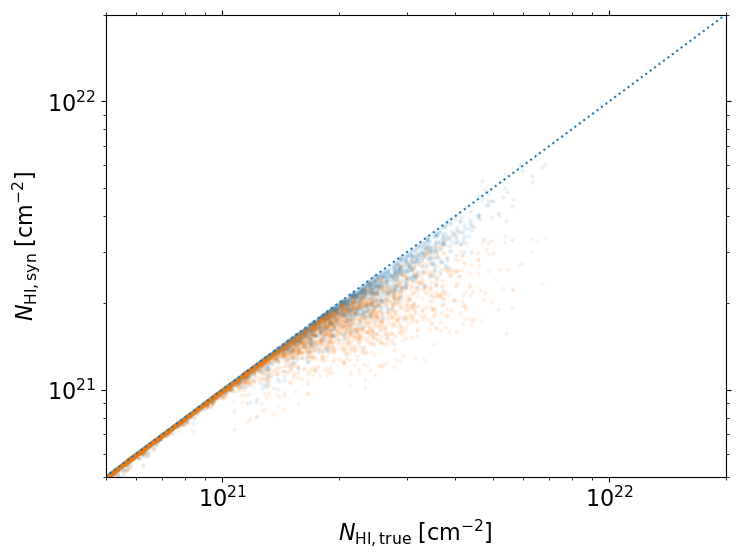

In [30]:
# comparison between true and observed
plt.scatter(NHI, NHobs, marker='.', alpha=0.1, lw=0)
plt.scatter(NHI, NHthin, marker='.', alpha=0.1, lw=0)
plt.plot([1e20,1e23],[1e20,1e23],ls=':')
plt.xlim(5e20,2e22)
plt.ylim(5e20,2e22)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N_{\rm HI,true}\;[{\rm cm}^{-2}]$')
plt.ylabel(r'$N_{\rm HI,syn}\;[{\rm cm}^{-2}]$')

In [31]:
ds.domain

{'all_grid_equal': True,
 'ngrid': 1,
 'le': array([-512., -512., -512.], dtype=float32),
 're': array([512., 512., 512.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 1024.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([256, 256, 256]),
 'ndim': 3,
 'time': 300.0002}

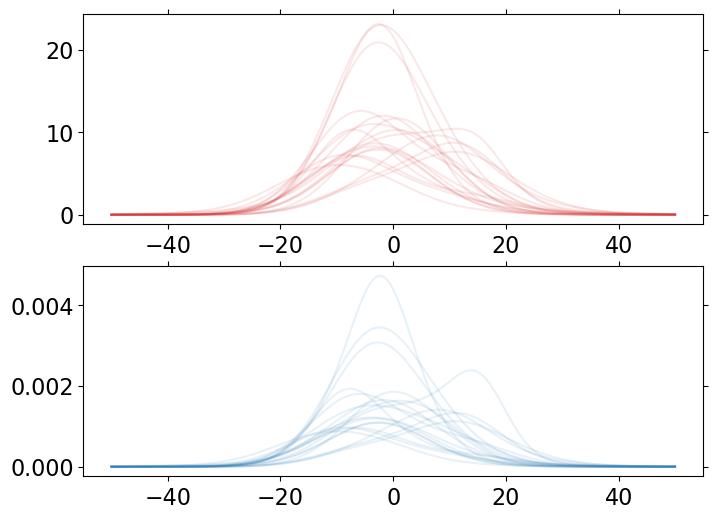

In [32]:
fig,axes = plt.subplots(2,1)
for (x,y) in xypair_sel:
    i = int((x - xmin - 0.5*ds.domain['dx'][0])/ds.domain['dx'][0])
    j = int((y - ymin - 0.5*ds.domain['dx'][1])/ds.domain['dx'][1])
    plt.sca(axes[0])
    plt.plot(vch, TB[:,j,i], c='tab:red', alpha=0.1);
    plt.sca(axes[1])
    plt.plot(vch, tau[:,j,i], c='tab:blue', alpha=0.1);

## Reading from fits file

In [33]:
from astropy.io import fits

hdul = fits.open(fname_fits)

In [34]:
vmin, vmax, dv = hdul[0].header['vmin'], hdul[0].header['vmax'], hdul[0].header['dv']
vch = np.arange(vmin, vmax + 0.5*dv, dv)
TB = hdul[1].data
tau = hdul[2].data


In [35]:
NHobs = 1.813e18*(TB*(tau + 1e-4)/(1-np.exp(-(tau + 1e-4)))).sum(axis=0)*dv

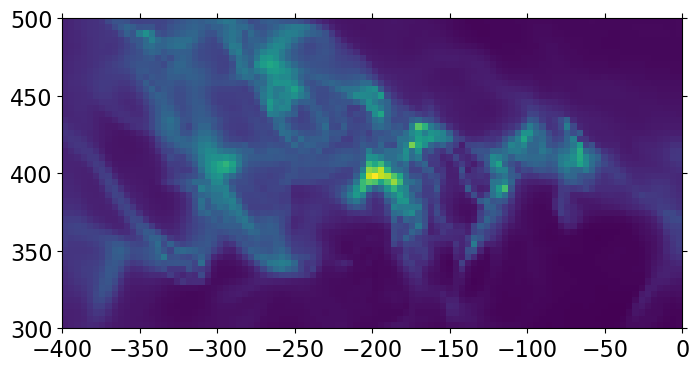

In [36]:
plt.imshow(NHobs,extent=(xmin,xmax,ymin,ymax),origin='lower')
plt.gca().set_aspect('equal')

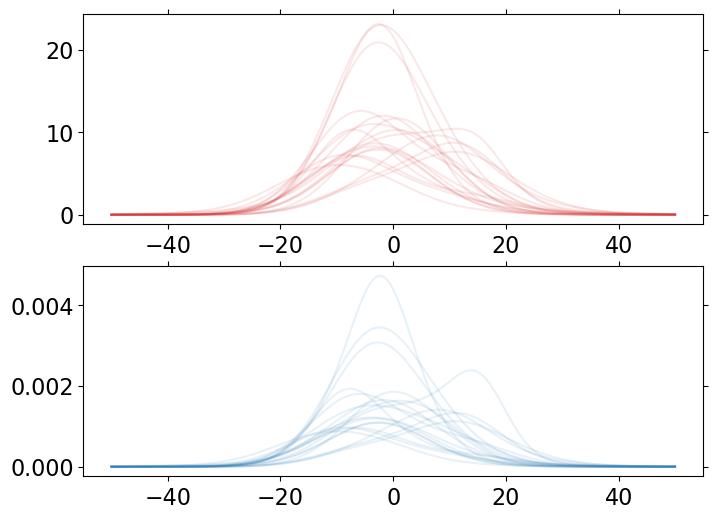

In [37]:
fig,axes = plt.subplots(2,1)

for (x,y) in xypair_sel:
    i = int((x - xmin - 0.5*ds.domain['dx'][0])/ds.domain['dx'][0])
    j = int((y - ymin - 0.5*ds.domain['dx'][2])/ds.domain['dx'][1])
    plt.sca(axes[0])
    plt.plot(vch, TB[:,j,i],c='tab:red',alpha=0.1);
    plt.sca(axes[1])
    plt.plot(vch, tau[:,j,i],c='tab:blue',alpha=0.1);

In [38]:
dsel

<xarray.Dataset>
Dimensions:  (z: 256, y: 50, x: 100)
Coordinates:
  * x        (x) float64 -398.0 -394.0 -390.0 -386.0 ... -14.0 -10.0 -6.0 -2.0
  * y        (y) float64 302.0 306.0 310.0 314.0 ... 486.0 490.0 494.0 498.0
  * z        (z) float64 -510.0 -506.0 -502.0 -498.0 ... 498.0 502.0 506.0 510.0
Data variables:
    nH       (z, y, x) float32 0.01351 0.01226 0.01032 ... 0.0002488 0.0001691
    P        (z, y, x) float32 1.3 1.345 1.532 2.246 ... 10.21 11.24 12.29 12.73
    vx       (z, y, x) float32 3.413 4.104 4.227 3.207 ... -59.61 -106.7 -136.6
    vy       (z, y, x) float32 1.212 2.167 3.518 6.818 ... 43.99 48.85 74.91
    vz       (z, y, x) float32 -1.569 -1.337 -0.865 ... 48.83 65.62 86.08
    T        (z, y, x) float32 1.33e+04 1.408e+04 ... 3.702e+06 5.644e+06
Attributes:
    all_grid_equal:  True
    ngrid:           1
    le:              [-512. -512. -512.]
    re:              [512. 512. 512.]
    dx:              [4. 4. 4.]
    Lx:              [1024. 1024. 1024.]
    center:          [0. 0. 0.]
    Nx:              [256 256 256]
    ndim:            3
    time:            300.0002

## Calculate chemical abundances (see KimJG+2023, Ch 16 in Draine (2011), Sec 2.2.5 in Armillotta+2021, etc.)

In [39]:
Z_d = 1.0 # dust abundance scaled to solar
Z_g = 1.0 # gas metallicity scaled to solar
xH2 = 0.0 # assume zero H2 for now

xCstd = 1.6e-4
xOstd = 3.2e-4
xCtot = Z_g*xCstd # Carbon abundance in gas phase
xCII = xCtot

# Assume uniform FUV radiation field and CR ionization rate (e.g., Indriolo+2015)
xi_cr = 2e-16

In [40]:
from cool import coeff_alpha_rr_H,coeff_alpha_gr_H

G_PE = 1.0
xM = xCII # abundance of metal ions
alpha_gr = 2.83e-14 # grain assisted recombination; assume constant (representative for CNM) for now
alpha_rr = coeff_alpha_rr_H(dsel['T'])

beta = xi_cr/(alpha_rr*dsel['nH'])
gamma = alpha_gr/alpha_rr
dsel['xHII'] = (np.sqrt((beta + gamma + xM)**2 + 4.0*beta) - (beta + gamma + xM))/2
# dsel = dsel.where((dsel.xHII < 1.0) & (dsel.T < T_thres))
dsel['xe'] = xM + dsel['xHII']
dsel['xHI'] = 1 - dsel['xHII']

## density vs. electron abundance

* High-temperature gas should be excluded for mock observation

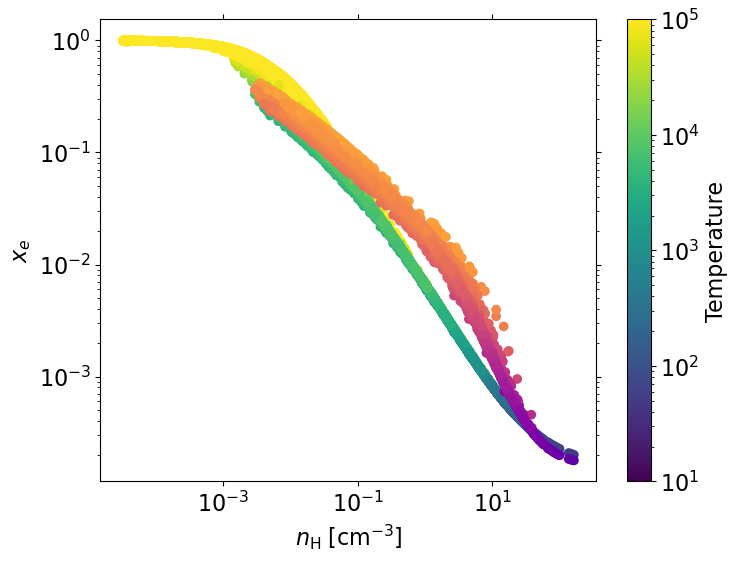

In [41]:
cmap = plt.cm.jet
norm = LogNorm(1e1,1e5)
sc = plt.scatter(dsel['nH'].data.flatten()[::20], dsel['xe'].data.flatten()[::20],
                 c=dsel['T'].data.flatten()[::20], norm=norm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_{\rm H}\;[{\rm cm}^{-3}]$')
plt.ylabel(r'$x_e$')
plt.colorbar(sc, label='Temperature')

# IMPORTANT NOTE
# xe should be obtained iteratively until convergence..here we do just one iteration
alpha_gr = coeff_alpha_gr_H(dsel['T'], G_PE, dsel['xe']*dsel['nH'], Z_d)
gamma = alpha_gr/alpha_rr
dsel['xHII'] = (np.sqrt((beta + gamma + xM)**2 + 4.0*beta) - (beta + gamma + xM))/2
dsel['xe'] = xM + dsel['xHII']
dsel['xHI'] = 1 - dsel['xHII']
dsel = dsel.where((dsel.xHII < 1.0) & (dsel.T < T_thres))

sc = plt.scatter(dsel['nH'].data.flatten()[::20], dsel['xe'].data.flatten()[::20],
                 c=dsel['T'].data.flatten()[::20], norm=norm, cmap=plt.cm.plasma)

## Level populations of OI

* Energy level diagram for OI can be found in Appendix C of Draine (2001)

In [42]:
from cool import get_OI_lev

f0,f1,f2 = get_OI_lev(dsel['nH'], dsel['T'], dsel['xe'], dsel['xHI'], 0.0)
xOtot = xOstd*Z_g
dsel['xOI'] = xOtot*(1.0 - dsel['xHII'])

In [43]:
from cool import coolCII

A10OI = 8.910e-05
E10OI = 3.144e-14
# Cooling rate per hydrogen for OI 63 micron
nLambda_OI = f1*A10OI*E10OI*dsel['xOI']
# Cooling rate per hydrogen for OI 63 micron
nLambda_CII = coolCII(dsel['nH'], dsel['T'], dsel['xe'], dsel['xHI'], 0.0, xCII)

Text(0, 0.5, '$n\\Lambda\\;[{\\rm erg}\\,{\\rm s}^{-1}]$')

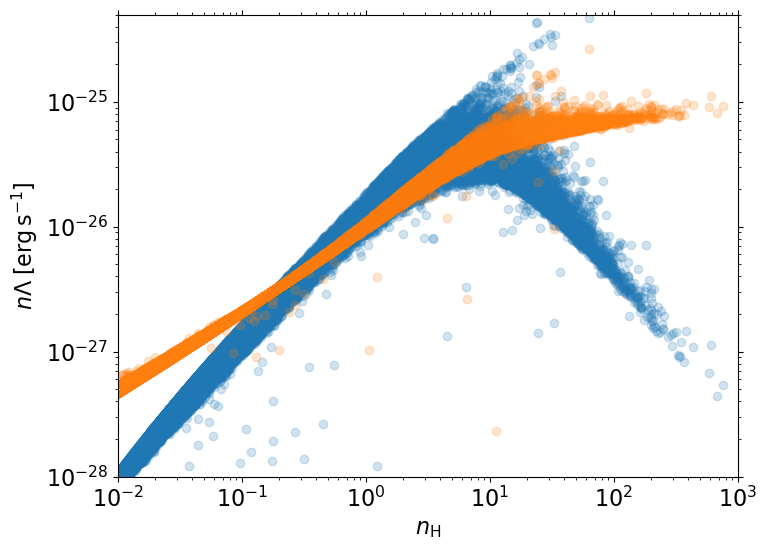

In [44]:
plt.scatter(dsel['nH'].data.flatten(), nLambda_OI.data.flatten(), alpha=0.2)
plt.scatter(dsel['nH'].data.flatten(), nLambda_CII.data.flatten(), alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1e3)
plt.ylim(1e-28,5e-25)
plt.xlabel(r'$n_{\rm H}$')
plt.ylabel(r'$n\Lambda\;[{\rm erg}\,{\rm s}^{-1}]$')

In [45]:
from cool import coolCII, coolOI

# import inspect
# inspect.getsourcelines(coolCII)
# inspect.getsourcelines(coolOI)

In [46]:
help(coolCII)

Help on function coolCII in module cool:

coolCII(nH, T, xe, xHI, xH2, xCII)



In [ ]:
# from cool import get_xCII, coeff_kcoll_H, coeff_alpha_rr_H, coeff_alpha_gr_H, coolHI, \
#     coolRec, coolCII, coolOI, coolHIion
# from cool import coolCII,coolneb,coolLya,coolrecH,coolffH,coolHI

# from scipy.optimize import brentq

# def get_xHII(nH, xe, xH2, xeM, T, xi_CR, G_PE, Z_d, zeta_pi, gr_rec):
    
#     kcoll = coeff_kcoll_H(T)
#     kcr = (1.5 + 2.3*xH2)*xi_CR  # assume xH2=0
#     alpha_rr = coeff_alpha_rr_H(T)
#     if gr_rec:
#         alpha_gr = coeff_alpha_gr_H(T, G_PE, nH*xe, Z_d)
#     else:
#         alpha_gr = 0.0
        
#     a = 1.0 + kcoll/alpha_rr
#     b = (kcr + zeta_pi - kcoll*nH*(1.0 - xeM))/(alpha_rr*nH) + xeM + alpha_gr/alpha_rr
#     c = -(kcr + zeta_pi + xeM*nH*kcoll)/(alpha_rr*nH)
    
#     xHII_eq = (-b + np.sqrt(b**2 - 4*a*c))/(2.0*a)
    
#     return xHII_eq

# def f_xe(xe, xH2, nH, T, xi_CR, G_CI, G_PE, Z_d, Z_g, zeta_pi, xOstd, xCstd, gr_rec=True):
#     xCII_eq = get_xCII(nH, xe, xH2, T, Z_d, Z_g, xi_CR, G_PE, G_CI, xCstd, gr_rec)
#     xHII_eq = get_xHII(nH, xe, xH2, xCII_eq, T, xi_CR, G_PE, Z_d, zeta_pi, gr_rec)
#     xOII_eq = xHII_eq*xOstd
    
#     return xe - xHII_eq - xCII_eq - xOII_eq

# def get_xe_arr(nH, T, xH2, xeM, xi_CR, G_PE, G_CI, zeta_pi, Z_d, Z_g, 
#                xCstd, xOstd, gr_rec):
#     xHII = []
#     xCII = []
#     xOII = []
#     for nH_, T_ in zip(nH,T):
#         if T_ > 3.5e4:
#             xHII_ = get_xHII(nH_, xe, xH2, xeM, T_, xi_CR, G_PE, Z_d, zeta_pi, gr_rec)
#             xHII.append(xHII_)
#             xCII.append(xCstd*Z_g)
#             xOII.append(xHII_*Z_g*xOstd)
#         else:
#             eps = 1e-11
#             xe = brentq(f_xe, 1e-3, 1.3, args=(xH2, nH_, T_, xi_CR, G_CI, G_PE, Z_d, Z_g, 
#                                            zeta_pi, xOstd, xCstd, gr_rec))
#             xHII_ = get_xHII(nH_, xe, xH2, xeM, T_, xi_CR, G_PE, Z_d, zeta_pi, gr_rec)
#             xCII_ = get_xCII(nH_, xe, xH2, T_, Z_d, Z_g, xi_CR, G_PE, G_CI, xCstd, gr_rec)

#             xHII.append(xHII_)
#             xCII.append(xCII_)
#             xOII.append(xHII_*Z_g*xOstd)

#     xHII = np.array(xHII)
#     xCII = np.array(xCII)
#     xOII = np.array(xOII)
#     xOI = xOstd*Z_g - xOII
#     xe = xHII + xCII + xOII
    
#     return xe, xHII, xCII, xOII, xOI

In [ ]:

# xe_eq, xHII_eq, xCII_eq, xOII_eq, xOI_eq = get_xe_arr(dsel['nH'].data.flatten(), dsel['T'].data.flatten(),
#                                                       xH2, xeM0, xi_cr, G_PE,  G_CI,
#                                                       zeta_pi, Z_d, Z_g, xCstd, xOstd, gr_rec=gr_rec)